# CNN with MNIST Dataset

Architecture of our network is:
    
- (Input) -> [batch_size, 28, 28, 1]  >> Apply 32 filter of [5x5]
- (Convolutional layer 1)  -> [batch_size, 28, 28, 32]
- (ReLU 1)  -> [?, 28, 28, 32]
- (Max pooling 1) -> [?, 14, 14, 32]
- (Convolutional layer 2)  -> [?, 14, 14, 64] 
- (ReLU 2)  -> [?, 14, 14, 64] 
- (Max pooling 2)  -> [?, 7, 7, 64] 
- [fully connected layer 3] -> [1x1024]
- [ReLU 3]  -> [1x1024]
- [Drop out]  -> [1x1024]
- [fully connected layer 4] -> [1x10]

In [6]:
import tensorflow as tf

sess=tf.InteractiveSession()

## MNIST Data

In [11]:
import input_data
mnist=input_data.read_data_sets('MNIST_data',one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Initial parameters

In [13]:
width=28
height=28
flat=width*height # number of pixels in one image
class_output=10

## Input and output
Create place holders for inputs and outputs

In [14]:
x  = tf.placeholder(tf.float32, shape=[None, flat])
y_ = tf.placeholder(tf.float32, shape=[None, class_output])

## Converting images of the data set to tensors
The input image is 28 pixels by 28 pixels, 1 channel (grayscale). In this case, the first dimension is the <b>batch number</b> of the image, and can be of any size (so we set it to -1). The second and third dimensions are width and height, and the last one is the image channels.

In [15]:
x_image = tf.reshape(x, [-1,28,28,1])  
x_image

<tf.Tensor 'Reshape:0' shape=(?, 28, 28, 1) dtype=float32>

## Layer 1 (Conv)

The Size of the filter/kernel is 5x5; Input channels is 1 (grayscale); and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of convolution layer would be 28x28x32). In this step, we create a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]

In [16]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1)) # Filter
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # 32 biases for 32 outputs, 0.1=stddev

Instructions for updating:
Colocations handled automatically by placer.


<b>Strides</b> determines how much the window shifts by in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. [1, 2, 2, 1]

In [17]:
convolve1= tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1

Applying ReLU activation function in our convolutional layer $f(x) = max(0,x)$

In [18]:
h_conv1 = tf.nn.relu(convolve1)

Applying Max Pooling(2x2) in our Conv+ReLU layer

In [19]:
conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv1

<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 32) dtype=float32>

## Layer 2(Conv)

In [21]:
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1)) # Filter [height,width,channels,output filters]
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) # 64 biases for 64 outputs, 0.1=stddev

convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2

h_conv2 = tf.nn.relu(convolve2)

conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 64) dtype=float32>

## Layer 3(Fully Connected)

Here we will convert the matrix into a flat array to be able to create our probabilities with softmax.<br>
So, each matrix [7x7] will be converted to a matrix of [49x1], and then all of the 64 matrix will be connected, which make an array of size [3136x1]. We will connect it into another layer of size [1024x1]. So, the weight between these 2 layers will be [3136x1024]

In [22]:
layer2_matrix = tf.reshape(conv2, [-1, 7 * 7 * 64])

In [25]:
W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

#Dot product
fcl = tf.matmul(layer2_matrix, W_fc1) + b_fc1

#Applying ReLU activation function
h_fc1=tf.nn.relu(fcl)
h_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

## Dropout

Reducing overfitting putting some 0's at our matrix, so we can generelize our model.

In [26]:
keep_prob = tf.placeholder(tf.float32)
layer_drop = tf.nn.dropout(h_fc1, keep_prob)
layer_drop

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


<tf.Tensor 'dropout/mul:0' shape=(?, 1024) dtype=float32>

## Softmax

In [27]:
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1)) #1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]

fc=tf.matmul(layer_drop,W_fc2)+b_fc2

y_CNN=tf.nn.softmax(fc)
y_CNN

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>

## Define functions and train the model

In [28]:
# Loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_CNN), reduction_indices=[1]))

# Optimizer, we can use GradientDescent or Adagrad
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Counting how many predictions was classified correctly
correct_prediction = tf.equal(tf.argmax(y_CNN, 1), tf.argmax(y_, 1))

# Accuracy using average of correct cases
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Run session
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.cast instead.


In [29]:
# Train
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.16
step 100, training accuracy 0.92
step 200, training accuracy 0.92
step 300, training accuracy 0.92
step 400, training accuracy 0.96
step 500, training accuracy 0.92
step 600, training accuracy 0.96
step 700, training accuracy 0.94
step 800, training accuracy 0.96
step 900, training accuracy 1
step 1000, training accuracy 0.96
step 1100, training accuracy 0.96
step 1200, training accuracy 0.98
step 1300, training accuracy 0.96
step 1400, training accuracy 0.98
step 1500, training accuracy 0.94
step 1600, training accuracy 0.92
step 1700, training accuracy 1
step 1800, training accuracy 0.94
step 1900, training accuracy 0.96
step 2000, training accuracy 0.96
step 2100, training accuracy 0.96
step 2200, training accuracy 1
step 2300, training accuracy 0.98
step 2400, training accuracy 1
step 2500, training accuracy 0.94
step 2600, training accuracy 0.94
step 2700, training accuracy 0.98
step 2800, training accuracy 1
step 2900, training accuracy 1
step 3000,

## Evaluation

In [30]:
# evaluate in batches to avoid out-of-memory issues
n_batches = mnist.test.images.shape[0] // 50
cumulative_accuracy = 0.0
for index in range(n_batches):
    batch = mnist.test.next_batch(50)
    cumulative_accuracy += accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
print("test accuracy {}".format(cumulative_accuracy / n_batches))

test accuracy 0.9913000032305718


Using visualization to help us evaluate our model.

Looking all filters.

In [31]:
kernels = sess.run(tf.reshape(tf.transpose(W_conv1, perm=[2,3,0,1]),[32,-1]))

In [32]:
from utils import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import numpy as np

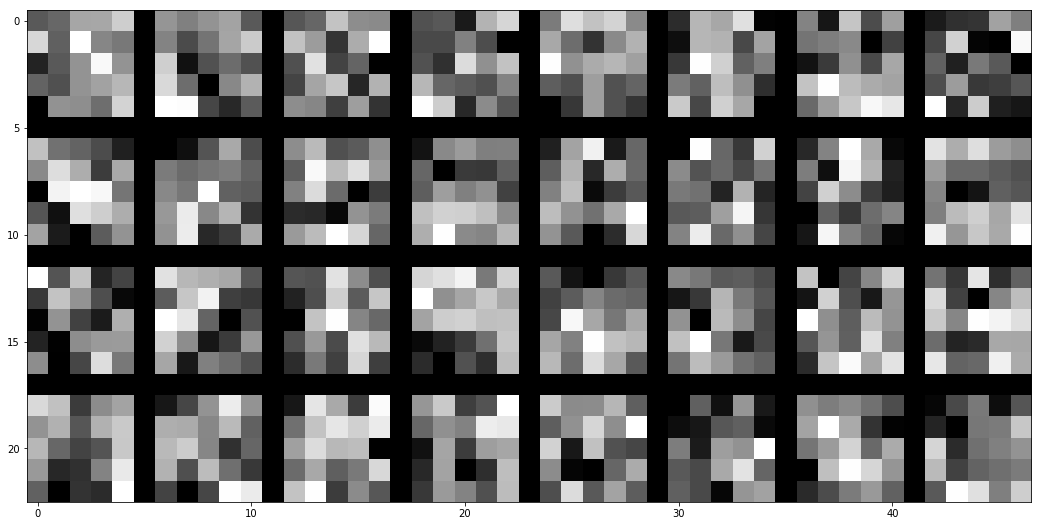

In [33]:
image = Image.fromarray(tile_raster_images(kernels, img_shape=(5, 5), tile_shape=(4, 8), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')

Checking the output after the first convolutional layer.

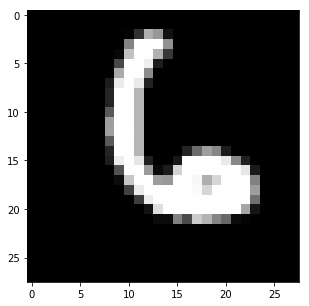

In [37]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = mnist.test.images[1]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")

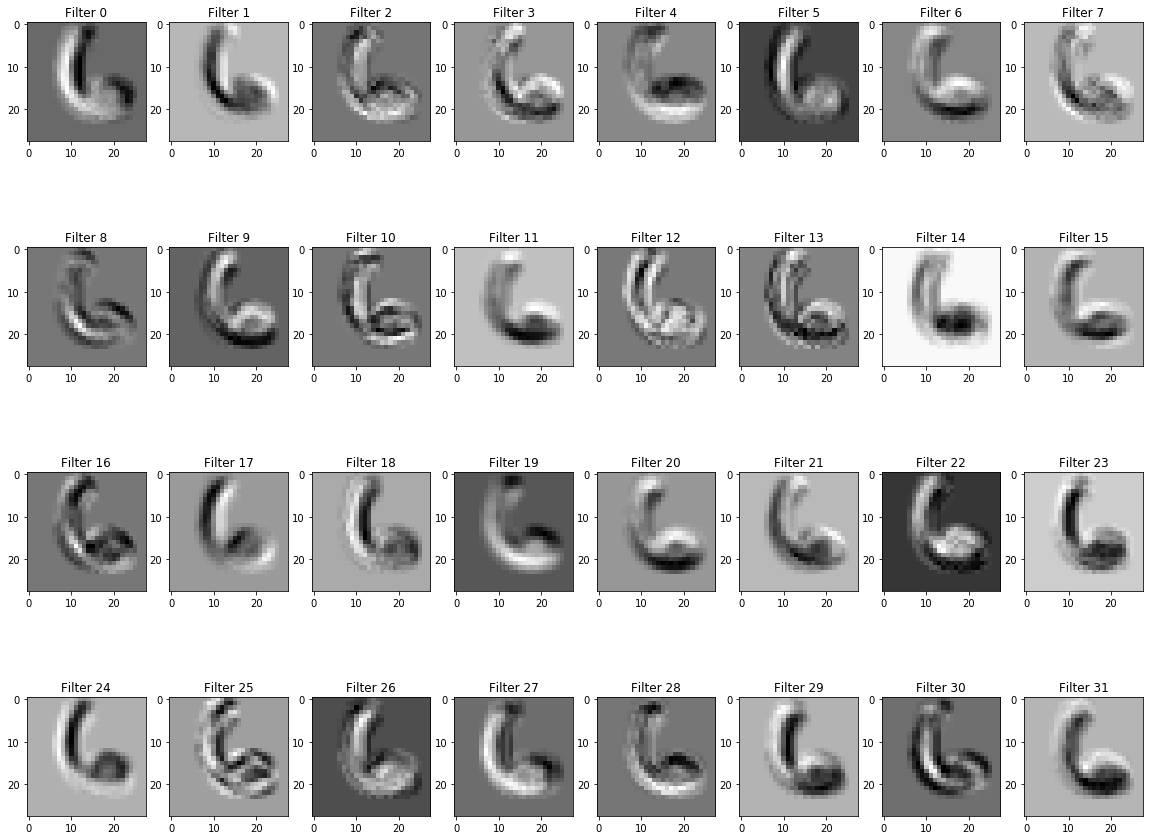

In [35]:
ActivatedUnits = sess.run(convolve1, feed_dict={x: np.reshape(sampleimage, [1,784],order='F'), keep_prob:1.0})
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

In [36]:
sess.close()